# Sentiment Analysis Convolutional Neural Network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import spacy
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [62]:
embedding_dim = 200
maxlen = 64
clear_tokenizer = True
clear_embedding_matrix = True
clear_model = True
glove_filepath = "glove/glove.6B.200d.txt"

In [63]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [75]:
def save_model(model, model_path="data/models/sentiment_analysis_cnn_model.json", weights_path="data/models/sentiment_analysis_cnn_model.hdf"):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weights_path)
    print("Saved model to data/models/sentiment_analysis_cnn_model.json")

In [65]:
training_df = pd.read_csv('data/clean_text.csv').sample(frac=1)
training_df.head()

,intensity,polarity,text
46231,0.5,1.0,It is often written that the American Revoluti...
46135,0.0,0.5,"When it comes to European history, I like to t..."
17687,1.0,0.0,"A Bit Stinky: Reminds me of the ""Fruit Bars"" f..."
97495,0.0,0.5,"is the capital city of France"" implies that th..."
89039,0.0,0.5,"This is quite excellent, but as I have 'Vogue ..."


In [66]:
train = training_df.sample(frac=0.8)
test = training_df.drop(train.index)
print("train len: ", len(train))
print("test len: ", len(test))

train len:  80000
test len:  20000


In [67]:
if os.path.exists('models/tokenizer.pickle') and not clear_tokenizer:
    with open('models/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    print("loaded tokenizer from models/tokenizer.pickle")
else:
    print("models/tokenizer.pickle not found (or ignored); creating a new tokenizer")
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(training_df["text"])
    # save for the future
    with open('models/tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

models/tokenizer.pickle not found (or ignored); creating a new tokenizer


In [68]:
if os.path.exists('models/embedding_matrix.pickle') and not clear_embedding_matrix:
    with open('models/embedding_matrix.pickle', 'rb') as handle:
        embedding_matrix = pickle.load(handle)
    print("loaded embedding_matrix from models/embedding_matrix.pickle")
else:
    print("models/embedding_matrix.pickle not found; creating a new embedding_matrix")
    vocab_size = len(tokenizer.word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(glove_filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in tokenizer.word_index:
                idx = tokenizer.word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    # save for the future
    with open('models/embedding_matrix.pickle', 'wb') as handle:
        pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("saving embedding_matrix to models/embedding_matrix.pickle")

models/embedding_matrix.pickle not found; creating a new embedding_matrix
saving embedding_matrix to models/embedding_matrix.pickle


In [69]:
vocab_size = len(tokenizer.word_index) + 1

In [70]:
input_train = tokenizer.texts_to_sequences(train["text"].values)
input_test = tokenizer.texts_to_sequences(test["text"].values)

In [71]:
input_train = pad_sequences(input_train, padding='post', maxlen=maxlen)
input_test = pad_sequences(input_test, padding='post', maxlen=maxlen)

In [72]:
output_train = train["intensity"]
output_test = test["intensity"]

In [73]:
if os.path.exists("models/sentiment_analysis_cnn_model.json") and not clear_model:
    # load json and create model
    json_file = open("models/sentiment_analysis_cnn_model.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("models/sentiment_analysis_cnn_model.hdf")
    print("Loaded model from disk")
else:
    print("models/sentiment_analysis_cnn_model.json not found (or ignored); creating a new model")
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=True))
    model.add(keras.layers.GlobalMaxPool1D())
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

models/sentiment_analysis_cnn_model.json not found (or ignored); creating a new model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 64, 200)           61876400  
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                3216      
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 61,879,633
Trainable params: 61,879,633
Non-trainable params: 0
_________________________________________________________________


In [74]:
history = model.fit(input_train, output_train,
                    epochs=16,
                    verbose=True,
                    validation_data=(input_test, output_test),
                    batch_size=1024)
loss, accuracy = model.evaluate(input_test, output_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
save_model(model)

/Users/wlifferth/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 80000 samples, validate on 20000 samples
Epoch 1/16
80000/80000 [==============================] - 100s 1ms/step - loss: 0.6066 - acc: 0.6504 - val_loss: 0.4800 - val_acc: 0.7661
Epoch 2/16
80000/80000 [==============================] - 95s 1ms/step - loss: 0.4442 - acc: 0.7726 - val_loss: 0.4005 - val_acc: 0.7863
Epoch 3/16
80000/80000 [==============================] - 91s 1ms/step - loss: 0.3793 - acc: 0.8060 - val_loss: 0.3617 - val_acc: 0.8088
Epoch 4/16
80000/80000 [==============================] - 90s 1ms/step - loss: 0.3386 - acc: 0.8274 - val_loss: 0.3338 - val_acc: 0.8280
Epoch 5/16
80000/80000 [==============================] - 90s 1ms/step - loss: 0.3056 - acc: 0.8461 - val_loss: 0.3189 - val_acc: 0.8382
Epoch 6/16
80000/80000 [==============================] - 92s 1ms/step - loss: 0.2784 - acc: 0.8613 - val_loss: 0.3044 - val_acc: 0.8458
Epoch 7/16
80000/80000 [==============================] - 91s 1ms/step - loss: 0.2563 - acc: 0.8735 - val_loss: 0.3027 - val_ac

FileNotFoundError: [Errno 2] No such file or directory: 'models/sentiment_analysis_cnn_model.json'

In [76]:
save_model(model)


Consider using a TensorFlow optimizer from `tf.train`.
Saved model to data/models/sentiment_analysis_cnn_model.json


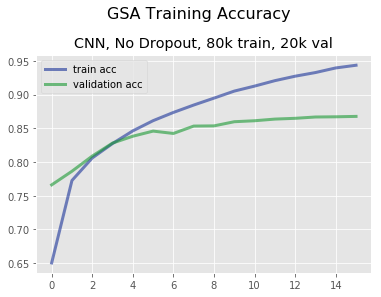

In [77]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
plt.style.use("ggplot")
plt.plot(acc, color=(0.1, 0.2, 0.6, 0.6), label="train acc", lw=3)
plt.plot(val_acc, color=(0.1, 0.6, 0.2, 0.6), label="validation acc", lw=3)
plt.suptitle("GSA Training Accuracy\n\n", fontsize=16, y=1.05)
plt.title("CNN, No Dropout, 80k train, 20k val", y=1.01)
plt.legend()
plt.savefig("graphs/GSA-CNN-ND.png")
plt.show()

<Figure size 432x288 with 0 Axes>